# OFDM MIMO Channel Estimation and Detection

In this notebook, we will evaluate some of the OFDM channel estimation and MIMO
detection algorithms available in Sionna PHY.

We will start by evaluating the mean square error (MSE) preformance of various channel estimation and interpolation methods.

Then, we will compare some of the MIMO detection algorithms under both perfect and imperfect channel state information (CSI) in terms of uncoded symbol error rate (SER) and coded bit error rate (BER).

The developed end-to-end models in this notebook are a great tool for benchmarking of MIMO receivers under realistic conditions.  They can be easily extended to new channel estimation methods or MIMO detection algorithms.

For MSE evaluations, the block diagram of the system looks as follows:

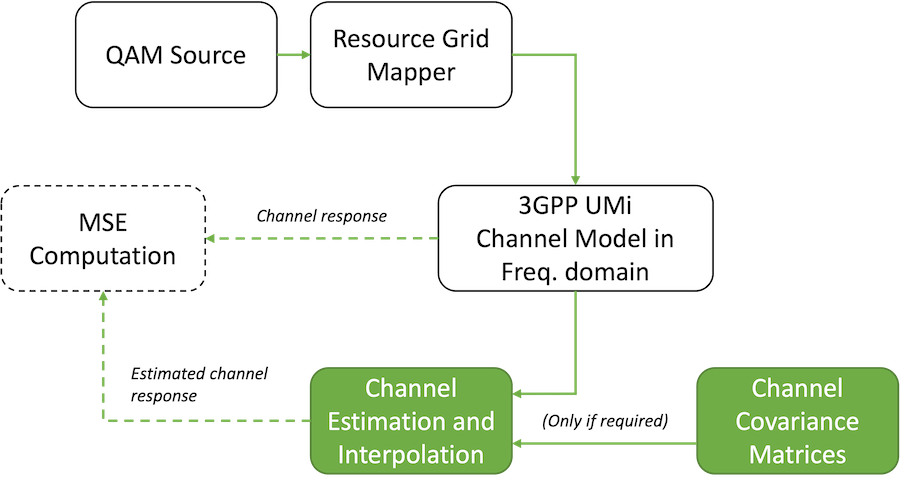

where the channel estimation module is highlighted as it is the focus of this evaluation. The channel covariance matrices are required for linear minimum mean square error (LMMSE) channel interpolation.

For uncoded SER evaluations, the block diagram of the system looks as follows:

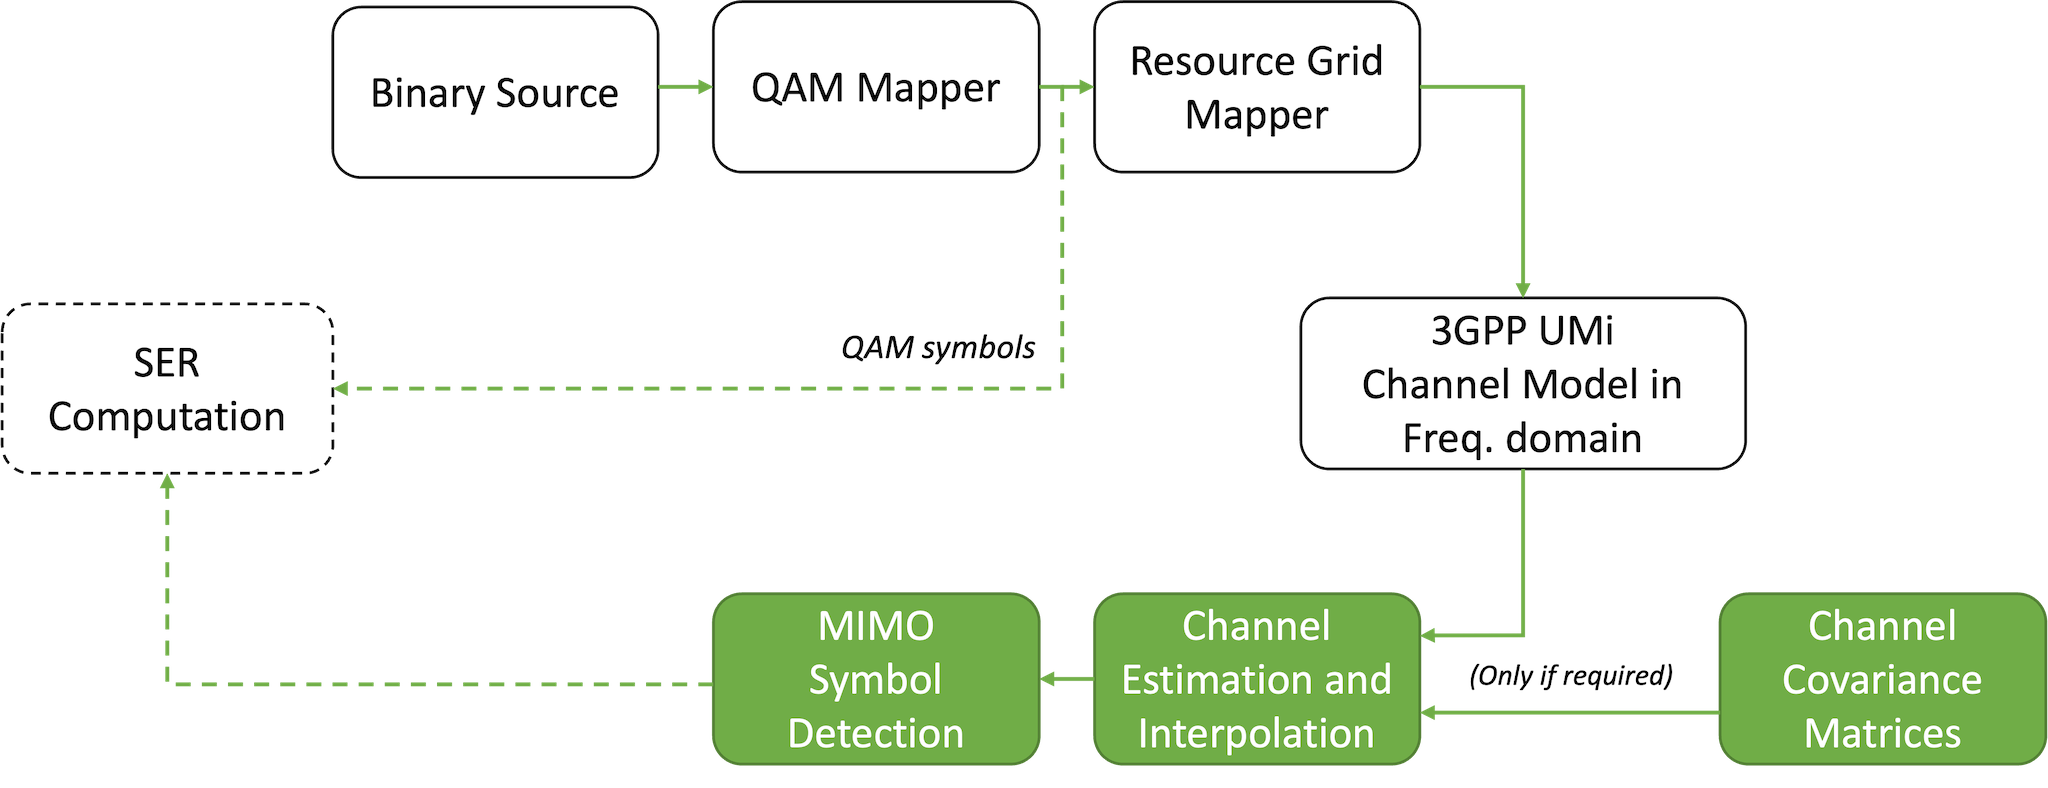

where the channel estimation and detection modules are highlighted as they are the focus of this evaluation.

Finally, for coded BER evaluations, the block diagram of the system looks as follows:

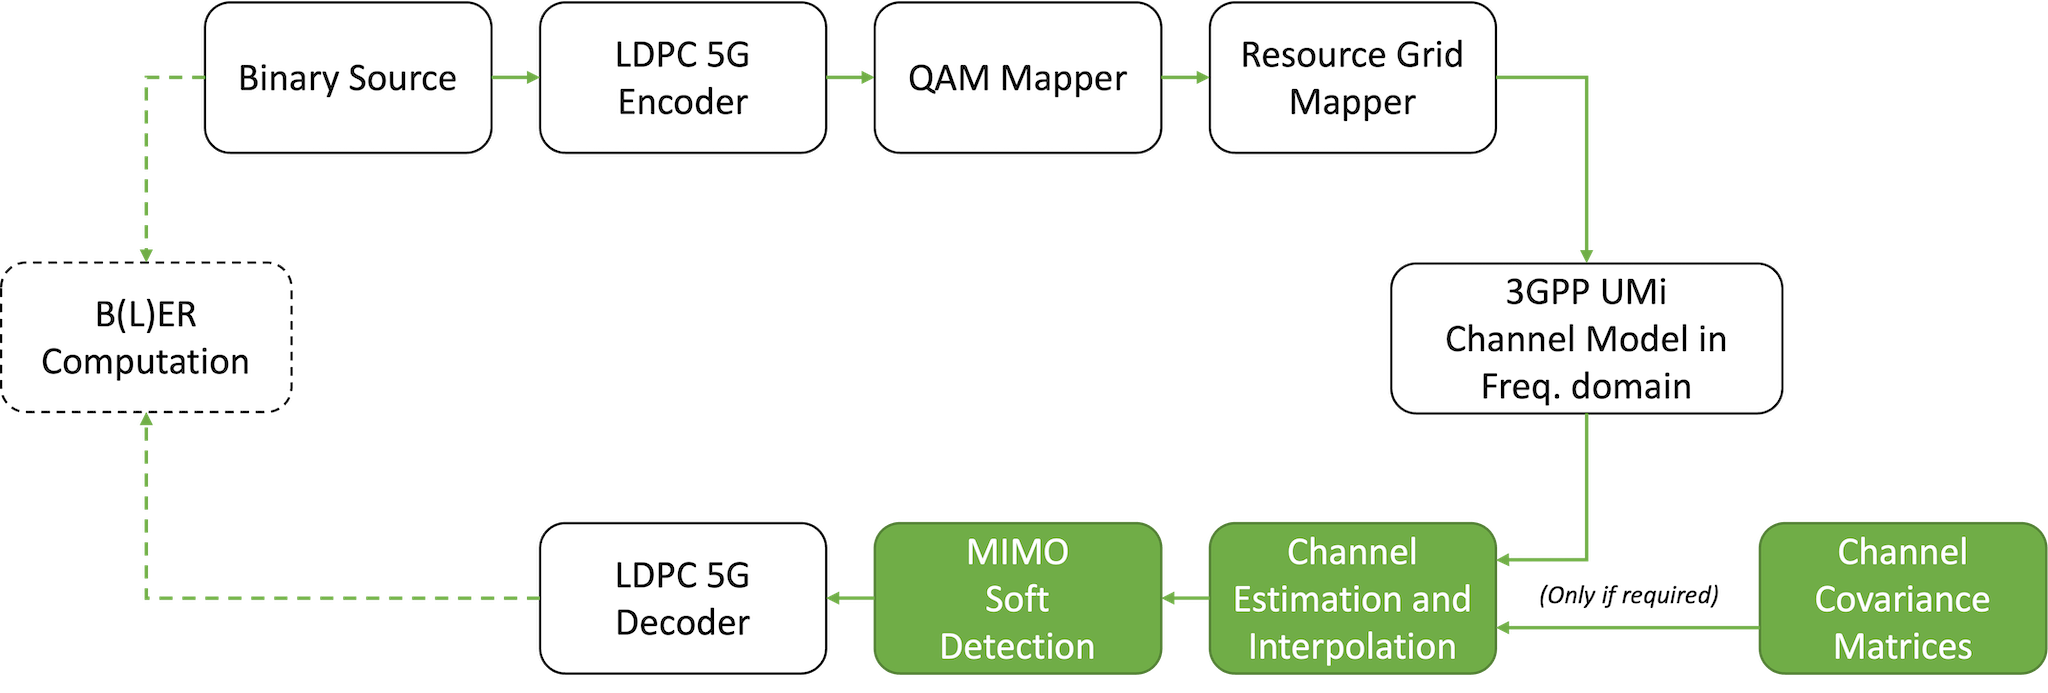

## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Simulations parameters](#Simulation-parameters)
* [Estimation of the channel time, frequency, and spatial covariance matrices](#Estimation-of-the-channel-time,-frequency,-and-spatial-covariance-matrices)
* [Loading the channel covariance matrices](#Loading-the-channel-covariance-matrices)
* [Comparison of OFDM estimators](#Comparison-of-OFDM-estimators)
* [Comparison of MIMO detectors](#Comparison-of-MIMO-detectors)

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna.phy
except ImportError as e:
    import sys
    if 'google.colab' in sys.modules:
       # Install Sionna in Google Colab
       print("Installing Sionna and restarting the runtime. Please run the cell again.")
       os.system("pip install sionna")
       os.kill(os.getpid(), 5)
    else:
       raise e

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.phy.config.seed = 42 # Set seed for reproducible random number generation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.phy import Block
from sionna.phy.mimo import StreamManagement
from sionna.phy.utils import sim_ber, ebnodb2no
from sionna.phy.mapping import Mapper, QAMSource, BinarySource
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, \
                            LMMSEInterpolator, LinearDetector, KBestDetector, \
                            EPDetector, MMSEPICDetector
from sionna.phy.channel import GenerateOFDMChannel, OFDMChannel, gen_single_sector_topology
from sionna.phy.channel.tr38901 import UMi, Antenna, PanelArray
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

## Simulation parameters

The next cell defines the simulation parameters used throughout this notebook.

This includes the OFDM waveform parameters, [antennas geometries and patterns](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.channel.tr38901.PanelArray), and the [3GPP UMi channel model](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.channel.tr38901.UMi).

In [3]:
NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 12*4 # 4 PRBs
SUBCARRIER_SPACING = 30e3 # Hz
CARRIER_FREQUENCY = 3.5e9 # Hz
SPEED = 3. # m/s

# The user terminals (UTs) are equipped with a single antenna
# with vertial polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni', # Omnidirectional antenna pattern
                     carrier_frequency=CARRIER_FREQUENCY)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
NUM_RX_ANT = 16
BS_ARRAY = PanelArray(num_rows_per_panel=4,
                      num_cols_per_panel=2,
                      polarization='dual',
                      polarization_type='cross',
                      antenna_pattern='38.901', # 3GPP 38.901 antenna pattern
                      carrier_frequency=CARRIER_FREQUENCY)

# 3GPP UMi channel model is considered
CHANNEL_MODEL = UMi(carrier_frequency=CARRIER_FREQUENCY,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=False)

## Estimation of the channel time, frequency, and spatial covariance matrices

The linear minimum mean square (LMMSE) interpolation method requires knowledge of the time (i.e., across OFDM symbols), frequency (i.e., across sub-carriers), and spatial (i.e., across receive antennas) covariance matrices of the channel frequency response.

These are estimated in this section using Monte Carlo sampling.

We explain below how this is achieved for the frequency covariance matrix. The same approach is used for the time and spatial covariance matrices.

Let $N$ be the number of sub-carriers.
The first step for estimating the frequency covariance matrix is to sample the channel model in order to build a set of frequency-domain channel realizations $\left\{ \mathbf{h}_k \right\}, 1 \leq k \leq K$, where $K$ is the number of samples and $\mathbf{h}_k  \in \mathbb{C}^{N}$ are complex-valued samples of the channel frequency response.

The frequency covariance matrix $\mathbf{R}^{(f)} \in \mathbb{C}^{N \times N}$ is then estimated by

\begin{equation}
\mathbf{R}^{(f)} \approx \frac{1}{K} \sum_{k = 1}^K \mathbf{h}_k \mathbf{h}_k^{\mathrm{H}}
\end{equation}

where we assume that the frequency-domain channel response has zero mean.

The following cells implement this process for all three dimensions (frequency, time, and space).


The next cell defines a [resource grid](https://nvlabs.github.io/sionna/phy/api/ofdm.html#resource-grid) and an [OFDM channel generator](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.phy.channel.GenerateOFDMChannel) for sampling the channel in the frequency domain.

In [4]:
rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                  fft_size=FFT_SIZE,
                  subcarrier_spacing=SUBCARRIER_SPACING)
channel_sampler = GenerateOFDMChannel(CHANNEL_MODEL, rg)

Then, a function that samples the channel is defined.
It randomly samples a network topology for every batch and for every batch example using the [appropriate utility function](https://nvlabs.github.io/sionna/phy/api/channel.wireless.html#sionna.phy.channel.gen_single_sector_topology).

In [5]:
def sample_channel(batch_size):
    # Sample random topologies
    topology = gen_single_sector_topology(batch_size, 1, 'umi', min_ut_velocity=SPEED, max_ut_velocity=SPEED)
    CHANNEL_MODEL.set_topology(*topology)

    # Sample channel frequency responses
    # [batch size, 1, num_rx_ant, 1, 1, num_ofdm_symbols, fft_size]
    h_freq = channel_sampler(batch_size)
    # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
    h_freq = h_freq[:,0,:,0,0]

    return h_freq

We now define a function that estimates the frequency, time, and spatial covariance matrcies using Monte Carlo sampling.

In [6]:
@tf.function(jit_compile=True) # Use XLA for speed-up
def estimate_covariance_matrices(num_it, batch_size):
    freq_cov_mat = tf.zeros([FFT_SIZE, FFT_SIZE], tf.complex64)
    time_cov_mat = tf.zeros([NUM_OFDM_SYMBOLS, NUM_OFDM_SYMBOLS], tf.complex64)
    space_cov_mat = tf.zeros([NUM_RX_ANT, NUM_RX_ANT], tf.complex64)
    for _ in tf.range(num_it):
        # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
        h_samples = sample_channel(batch_size)

        #################################
        # Estimate frequency covariance
        #################################
        # [batch size, num_rx_ant, fft_size, num_ofdm_symbols]
        h_samples_ = tf.transpose(h_samples, [0,1,3,2])
        # [batch size, num_rx_ant, fft_size, fft_size]
        freq_cov_mat_ = tf.matmul(h_samples_, h_samples_, adjoint_b=True)
        # [fft_size, fft_size]
        freq_cov_mat_ = tf.reduce_mean(freq_cov_mat_, axis=(0,1))
        # [fft_size, fft_size]
        freq_cov_mat += freq_cov_mat_

        ################################
        # Estimate time covariance
        ################################
        # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
        time_cov_mat_ = tf.matmul(h_samples, h_samples, adjoint_b=True)
        # [num_ofdm_symbols, num_ofdm_symbols]
        time_cov_mat_ = tf.reduce_mean(time_cov_mat_, axis=(0,1))
        # [num_ofdm_symbols, num_ofdm_symbols]
        time_cov_mat += time_cov_mat_

        ###############################
        # Estimate spatial covariance
        ###############################
        # [batch size, num_ofdm_symbols, num_rx_ant, fft_size]
        h_samples_ = tf.transpose(h_samples, [0,2,1,3])
        # [batch size, num_ofdm_symbols, num_rx_ant, num_rx_ant]
        space_cov_mat_ = tf.matmul(h_samples_, h_samples_, adjoint_b=True)
        # [num_rx_ant, num_rx_ant]
        space_cov_mat_ = tf.reduce_mean(space_cov_mat_, axis=(0,1))
        # [num_rx_ant, num_rx_ant]
        space_cov_mat += space_cov_mat_

    freq_cov_mat /= tf.complex(tf.cast(NUM_OFDM_SYMBOLS*num_it, tf.float32), 0.0)
    time_cov_mat /= tf.complex(tf.cast(FFT_SIZE*num_it, tf.float32), 0.0)
    space_cov_mat /= tf.complex(tf.cast(FFT_SIZE*num_it, tf.float32), 0.0)

    return freq_cov_mat, time_cov_mat, space_cov_mat

We then compute the estimates by executing the function defined in the previous cell.

The batch size and number of iterations determine the total number of samples, i.e.,

```
number of samples = batch_size x num_iterations
```

and hence control the tradeoff between the accuracy of the estimates and the time needed for their computation.

In [7]:
batch_size = 1000
num_iterations = 100
FREQ_COV_MAT, TIME_COV_MAT, SPACE_COV_MAT = estimate_covariance_matrices(batch_size, num_iterations)

Finally, the estimated matrices are saved (as numpy arrays) for future use.

In [8]:
# FREQ_COV_MAT : [fft_size, fft_size]
# TIME_COV_MAT : [num_ofdm_symbols, num_ofdm_symbols]
# SPACE_COV_MAT : [num_rx_ant, num_rx_ant]

np.save('freq_cov_mat', FREQ_COV_MAT.numpy())
np.save('time_cov_mat', TIME_COV_MAT.numpy())
np.save('space_cov_mat', SPACE_COV_MAT.numpy())

## Loading the channel covariance matrices

The next cell loads saved estimates of the time, frequency, and space covariance matrices.

In [9]:
FREQ_COV_MAT = np.load('freq_cov_mat.npy')
TIME_COV_MAT = np.load('time_cov_mat.npy')
SPACE_COV_MAT = np.load('space_cov_mat.npy')

We then visualize the loaded matrices.

As one can see, the frequency correlation slowly decays with increasing spectral distance.

The time-correlation is much stronger as the mobility low. The covariance matrix is hence very badly conditioned with rank almost equal to one.

The spatial covariance matrix has a regular structure which is determined by the array geometry and polarization of its elements.

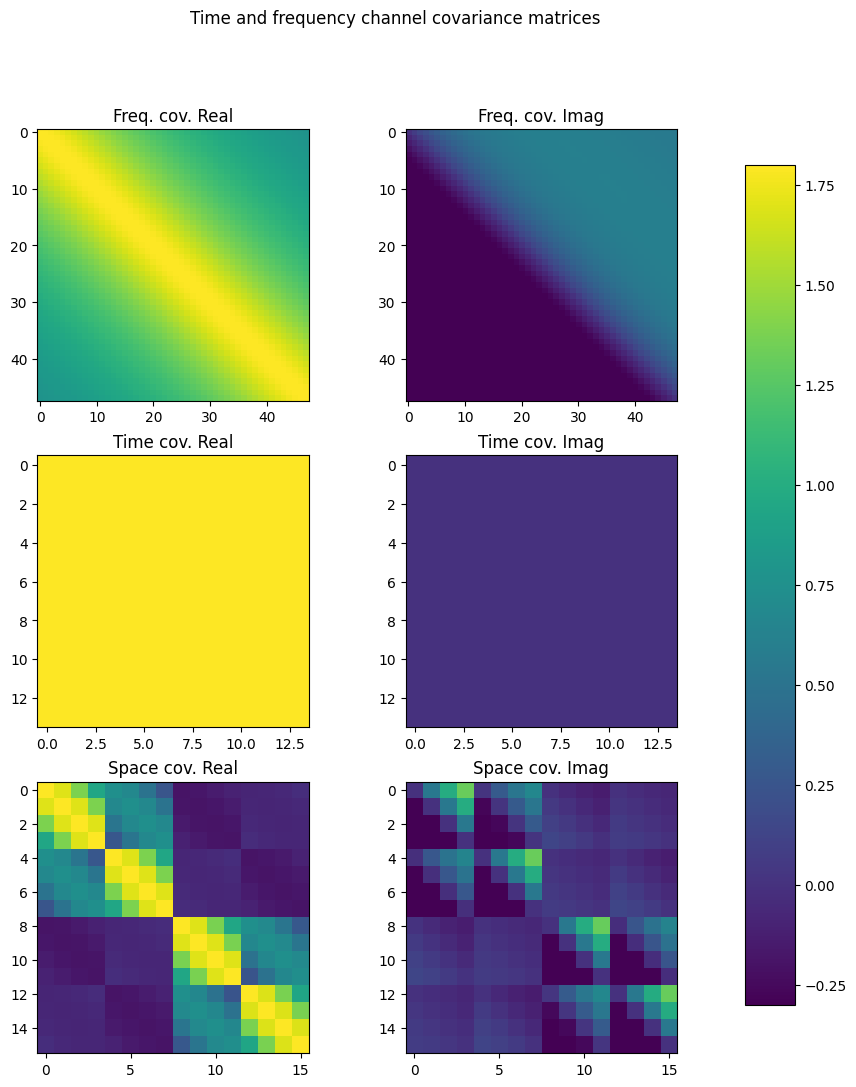

In [10]:
fig, ax = plt.subplots(3,2, figsize=(10,12))
fig.suptitle("Time and frequency channel covariance matrices")

ax[0,0].set_title("Freq. cov. Real")
im = ax[0,0].imshow(FREQ_COV_MAT.real, vmin=-0.3, vmax=1.8)
ax[0,1].set_title("Freq. cov. Imag")
im = ax[0,1].imshow(FREQ_COV_MAT.imag, vmin=-0.3, vmax=1.8)

ax[1,0].set_title("Time cov. Real")
im = ax[1,0].imshow(TIME_COV_MAT.real, vmin=-0.3, vmax=1.8)
ax[1,1].set_title("Time cov. Imag")
im = ax[1,1].imshow(TIME_COV_MAT.imag, vmin=-0.3, vmax=1.8)

ax[2,0].set_title("Space cov. Real")
im = ax[2,0].imshow(SPACE_COV_MAT.real, vmin=-0.3, vmax=1.8)
ax[2,1].set_title("Space cov. Imag")
im = ax[2,1].imshow(SPACE_COV_MAT.imag, vmin=-0.3, vmax=1.8)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

## Comparison of OFDM estimators

This section focuses on comparing the available OFDM channel estimators in Sionna for the considered setup.

OFDM channel estimation consists of two steps:

1. Channel estimation at pilot-carrying resource elements using [least-squares (LS)](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.phy.ofdm.LSChannelEstimator).

2. Interpolation for data-carrying resource elements, for which three methods are available in Sionna:

- [Nearest-neighbor](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.phy.ofdm.NearestNeighborInterpolator), which uses the channel estimate of the nearest pilot
- [Linear](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.phy.ofdm.LinearInterpolator), with optional averaging over the OFDM symbols (time dimension) for low mobility scenarios
- [LMMSE](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.phy.ofdm.LMMSEInterpolator), which requires knowledge of the time and frequency covariance matrices

The LMMSE interpolator also features optional spatial smoothin, which requires the spatial covarance matrix. The [API documentation](https://nvlabs.github.io/sionna/phy/api/ofdm.html#sionna.phy.ofdm.LMMSEInterpolator) explains in more detail how this interpolator operates.

### End-to-end model

In the next cell, we will create a Sionna Block which uses the interpolation method specified at initialization.

It computes the mean square error (MSE) for a specified batch size and signal-to-noise ratio (SNR) (in dB).

The following interpolation methods are available (set through the `int_method` parameter):

- `"nn"` : Nearest-neighbor interpolation
- `"lin"` : Linear interpolation
- `"lmmse"` : LMMSE interpolation

When LMMSE interpolation is used, it is required to specified the order in which interpolation and optional spatial smoothing is performed.
This is achieved using the `lmmse_order` parameter. For example, setting this parameter to `"f-t"` leads to frequency interpolation being performed first followed by time interpolation, and no spatial smoothing.
Setting it to `"t-f-s"` leads to time interpolation being performed first, followed by frequency interpolation, and finally spatial smoothing. 

In [11]:
class MIMOOFDMLink(Block):

    def __init__(self, int_method, lmmse_order=None, **kwargs):
        super().__init__(kwargs)

        assert int_method in ('nn', 'lin', 'lmmse')


        # Configure the resource grid
        rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                          fft_size=FFT_SIZE,
                          subcarrier_spacing=SUBCARRIER_SPACING,
                          num_tx=1,
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])
        self.rg = rg

        # Stream management
        # Only a sinlge UT is considered for channel estimation
        sm = StreamManagement([[1]], 1)

        ##################################
        # Transmitter
        ##################################

        self.qam_source = QAMSource(num_bits_per_symbol=2) # Modulation order does not impact the channel estimation. Set to QPSK
        self.rg_mapper = ResourceGridMapper(rg)

        ##################################
        # Channel
        ##################################

        self.channel = OFDMChannel(CHANNEL_MODEL, rg, return_channel=True)

        ###################################
        # Receiver
        ###################################

        # Channel estimation
        freq_cov_mat = tf.constant(FREQ_COV_MAT, tf.complex64)
        time_cov_mat = tf.constant(TIME_COV_MAT, tf.complex64)
        space_cov_mat = tf.constant(SPACE_COV_MAT, tf.complex64)
        if int_method == 'nn':
            self.channel_estimator = LSChannelEstimator(rg, interpolation_type='nn')
        elif int_method == 'lin':
            self.channel_estimator = LSChannelEstimator(rg, interpolation_type='lin')
        elif int_method == 'lmmse':
            lmmse_int_freq_first = LMMSEInterpolator(rg.pilot_pattern, time_cov_mat, freq_cov_mat, space_cov_mat, order=lmmse_order)
            self.channel_estimator = LSChannelEstimator(rg, interpolator=lmmse_int_freq_first)

    @tf.function
    def call(self, batch_size, snr_db):


        ##################################
        # Transmitter
        ##################################

        x = self.qam_source([batch_size, 1, 1, self.rg.num_data_symbols])
        x_rg = self.rg_mapper(x)

        ##################################
        # Channel
        ##################################

        no = tf.pow(10.0, -snr_db/10.0)
        topology = gen_single_sector_topology(batch_size, 1, 'umi', min_ut_velocity=SPEED, max_ut_velocity=SPEED)
        CHANNEL_MODEL.set_topology(*topology)
        y_rg, h_freq = self.channel(x_rg, no)

        ###################################
        # Channel estimation
        ###################################

        h_hat,_ = self.channel_estimator(y_rg,no)

        ###################################
        # MSE
        ###################################

        mse = tf.reduce_mean(tf.square(tf.abs(h_freq-h_hat)))

        return mse

The next cell defines a function for evaluating the mean square error (MSE) of a `model` over a range of SNRs (`snr_dbs`).

The `batch_size` and `num_it` parameters control the number of samples used to compute the MSE for each SNR value.

In [12]:
def evaluate_mse(model, snr_dbs, batch_size, num_it):

    # Casting model inputs to TensorFlow types to avoid
    # re-building of the graph
    snr_dbs = tf.cast(snr_dbs, tf.float32)
    batch_size = tf.cast(batch_size, tf.int32)

    mses = []
    for snr_db in snr_dbs:

        mse_ = 0.0
        for _ in range(num_it):
            mse_ += model(batch_size, snr_db).numpy()
        # Averaging over the number of iterations
        mse_ /= float(num_it)
        mses.append(mse_)

    return mses

The next cell defines the evaluation parameters.

In [13]:
# Range of SNR (in dB)
SNR_DBs = np.linspace(-10.0, 20.0, 20)

# Number of iterations and batch size.
# These parameters control the number of samples used to compute each SNR value.
# The higher the number of samples is, the more accurate the MSE estimation is, at
# the cost of longer compute time.
BATCH_SIZE = 512
NUM_IT = 10

# Interpolation/filtering order for the LMMSE interpolator.
# All valid configurations are listed.
# Some are commented to speed-up simulations.
# Uncomment configurations to evaluate them!
ORDERS = ['s-t-f', # Space - time - frequency
          #'s-f-t', # Space - frequency - time
          #'t-s-f', # Time - space - frequency
          't-f-s', # Time - frequency - space
          #'f-t-s', # Frequency - time - space
          #'f-s-t', # Frequency - space- time
          #'f-t',   # Frequency - time (no spatial smoothing)
          't-f'   # Time - frequency (no spatial smoothing)
          ]

The next cell evaluates the nearest-neighbor, linear, and LMMSE interpolator.
For the LMMSE interpolator, we loop through the configuration listed in `ORDERS`.

In [14]:
MSES = {}

# Nearest-neighbor interpolation
e2e = MIMOOFDMLink("nn")
MSES['nn'] = evaluate_mse(e2e, SNR_DBs, BATCH_SIZE, NUM_IT)

# Linear interpolation
e2e = MIMOOFDMLink("lin")
MSES['lin'] = evaluate_mse(e2e, SNR_DBs, BATCH_SIZE, NUM_IT)

# LMMSE
for order in ORDERS:
    e2e = MIMOOFDMLink("lmmse", order)
    MSES[f"lmmse: {order}"] = evaluate_mse(e2e, SNR_DBs, BATCH_SIZE, NUM_IT)


Finally, we plot the MSE.

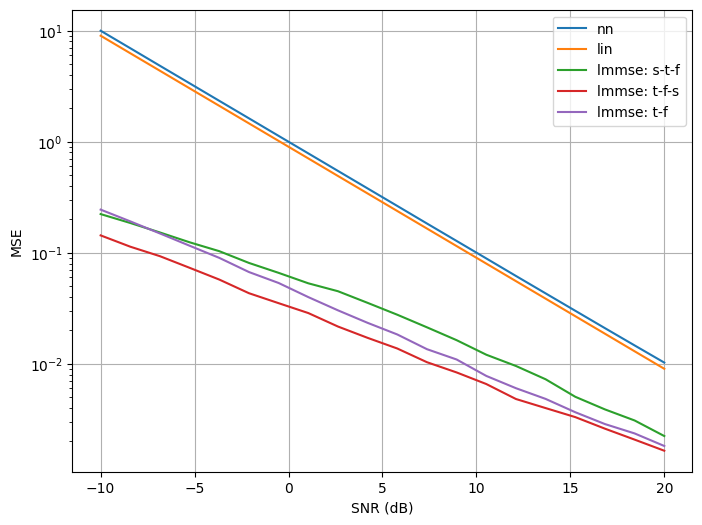

In [15]:
plt.figure(figsize=(8,6))

for est_label in MSES:
    plt.semilogy(SNR_DBs, MSES[est_label], label=est_label)

plt.xlabel(r"SNR (dB)")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

Unsurprisingly, the LMMSE interpolator leads to more accurate estimates compared to the two other methods, as it leverages knowledge of the the channel statistics.
Moreover, the order in which the LMMSE interpolation steps are performed strongly impacts the accuracy of the estimator. This is because the LMMSE interpolation operates in one dimension at a time which is not equivalent to full-blown LMMSE estimation across all dimensions at one.

Also note that the order that leads to the best accuracy depends on the channel statistics. As a rule of thumb, it might be good to start with the dimension that is most strongly correlated (i.e., time in our example).

## Comparison of MIMO detectors

An OFDM MIMO receiver consists of two stages: **OFDM channel estimation** and **MIMO detection**.

While the previous section focused on OFDM channel estimation, this section focuses now on MIMO detection.

The following MIMO detection algorithms, all available out-of-the-box in Sionna, are considered:

- [LMMSE equalization followed by APP demapping](https://nvlabs.github.io/sionna/phy/api/mimo.html#sionna.phy.mimo.LinearDetector)
- [K-Best detection](https://nvlabs.github.io/sionna/phy/api/mimo.html#sionna.phy.mimo.KBestDetector)
- [EP detection](https://nvlabs.github.io/sionna/phy/api/mimo.html#sionna.phy.mimo.EPDetector)
- [MMSE-PIC detection](https://nvlabs.github.io/sionna/phy/api/mimo.html#sionna.phy.mimo.MMSEPICDetector)

Both perfect and imperfect channel state information is considered in the simulations.
LS estimation combined with LMMSE interpolation is used, with time-frequency-space smoothing (in this order, i.e.,  `order='t-f-s'`).

### End-to-end model

An end-to-end model is created in the next cell as a Sionna Block, which uses the detection method specified at initialization.

It computes either the coded bit error rate (BER) or the uncoded symbol error rate (SER), for a specified batch size, $E_b/N_0$ (in dB), and QAM modulation with a specified modulation order.
When computing the BER, a 5G LDPC code is used with the specified coderate.

The following MIMO detection methods are considered (set through the `det_param` parameter):

- `"lmmse"` : No parameter needed
- `"k-best"` : List size `k`, defaults to 64
- `"ep"` : Number of iterations `l`, defaults to 10
- `"mmse-pic"` : Number of self-iterations `num_it`, defaults to 4

The `det_param` parameter corresponds to either `k`, `l`, or `num_it`, for K-Best, EP, or MMSE-PIC, respectively. If set to `None`, a default value is used according to the selected detector.

The `perf_csi` parameter controls whether perfect CSI is assumed or not. If set to `False`, then LS combined with LMMSE interpolation is used to estimate the channel.

You can easily add your own MIMO detector and channel estimator to this model for a fair and realistic benchmark.

In [16]:
class MIMOOFDMLink(Block):

    def __init__(self, output, det_method, perf_csi, num_tx, num_bits_per_symbol, det_param=None, coderate=0.5, **kwargs):
        super().__init__(kwargs)

        assert det_method in ('lmmse', 'k-best', 'ep', 'mmse-pic'), "Unknown detection method"

        self._output = output
        self.num_tx = num_tx
        self.num_bits_per_symbol = num_bits_per_symbol
        self.coderate = coderate
        self.det_method = det_method
        self.perf_csi = perf_csi

        # Configure the resource grid
        rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                          fft_size=FFT_SIZE,
                          subcarrier_spacing=SUBCARRIER_SPACING,
                          num_tx=num_tx,
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])
        self.rg = rg

        # Stream management
        sm = StreamManagement(np.ones([1,num_tx], int), 1)

        # Codeword length and number of information bits per codeword
        n = int(rg.num_data_symbols*num_bits_per_symbol)
        k = int(coderate*n)
        self.n = n
        self.k = k

        # If output is symbol, then no FEC is used and hard decision are output
        hard_out = (output == "symbol")
        coded = (output == "bit")
        self.hard_out = hard_out
        self.coded = coded

        ##################################
        # Transmitter
        ##################################

        self.binary_source = BinarySource()
        self.mapper = Mapper(constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol, return_indices=True)
        self.rg_mapper = ResourceGridMapper(rg)
        if coded:
            self.encoder = LDPC5GEncoder(k, n, num_bits_per_symbol=num_bits_per_symbol)

        ##################################
        # Channel
        ##################################

        self.channel = OFDMChannel(CHANNEL_MODEL, rg, return_channel=True)

        ###################################
        # Receiver
        ###################################

        # Channel estimation
        if not self.perf_csi:
            freq_cov_mat = tf.constant(FREQ_COV_MAT, tf.complex64)
            time_cov_mat = tf.constant(TIME_COV_MAT, tf.complex64)
            space_cov_mat = tf.constant(SPACE_COV_MAT, tf.complex64)
            lmmse_int_time_first = LMMSEInterpolator(rg.pilot_pattern, time_cov_mat, freq_cov_mat, space_cov_mat, order='t-f-s')
            self.channel_estimator = LSChannelEstimator(rg, interpolator=lmmse_int_time_first)

        # Detection
        if det_method == "lmmse":
            self.detector = LinearDetector("lmmse", output, "app", rg, sm, constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol, hard_out=hard_out)
        elif det_method == 'k-best':
            if det_param is None:
                k = 64
            else:
                k = det_param
            self.detector = KBestDetector(output, num_tx, k, rg, sm, constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol, hard_out=hard_out)
        elif det_method == "ep":
            if det_param is None:
                l = 10
            else:
                l = det_param
            self.detector = EPDetector(output, rg, sm, num_bits_per_symbol, l=l, hard_out=hard_out)
        elif det_method == 'mmse-pic':
            if det_param is None:
                l = 4
            else:
                l = det_param
            self.detector = MMSEPICDetector(output, 'app', rg, sm, num_iter=l, constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol, hard_out=hard_out)

        if coded:
            self.decoder = LDPC5GDecoder(self.encoder, hard_out=False)

    @tf.function
    def call(self, batch_size, ebno_db):


        ##################################
        # Transmitter
        ##################################

        if self.coded:
            b = self.binary_source([batch_size, self.num_tx, 1, self.k])
            c = self.encoder(b)
        else:
            c = self.binary_source([batch_size, self.num_tx, 1, self.n])
        bits_shape = tf.shape(c)
        x,x_ind = self.mapper(c)
        x_rg = self.rg_mapper(x)

        ##################################
        # Channel
        ##################################

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol, self.coderate, resource_grid=self.rg)
        topology = gen_single_sector_topology(batch_size, self.num_tx, 'umi', min_ut_velocity=SPEED, max_ut_velocity=SPEED)
        CHANNEL_MODEL.set_topology(*topology)
        y_rg, h_freq = self.channel(x_rg, no)

        ###################################
        # Receiver
        ###################################

        # Channel estimation
        if self.perf_csi:
            h_hat = h_freq
            err_var = 0.0
        else:
            h_hat,err_var = self.channel_estimator(y_rg,no)

        # Detection
        if self.det_method == "mmse-pic":
            if self._output == "bit":
                prior_shape = bits_shape
            elif self._output == "symbol":
                prior_shape = tf.concat([tf.shape(x), [self.num_bits_per_symbol]], axis=0)
            prior = tf.zeros(prior_shape)
            det_out = self.detector(y_rg,h_hat,prior,err_var,no)
        else:
            det_out = self.detector(y_rg,h_hat,err_var,no)

        # (Decoding) and output
        if self._output == "bit":
            llr = tf.reshape(det_out, bits_shape)
            b_hat = self.decoder(llr)
            return b, b_hat
        elif self._output == "symbol":
            x_hat = tf.reshape(det_out, tf.shape(x_ind))
            return x_ind, x_hat

The following function is used to evaluate all of the considered detectors for a given setup: It instantiates the end-to-end systems, runs the simulations, and returns the BER or SER.

In [17]:
def run_sim(num_tx, num_bits_per_symbol, output, ebno_dbs, perf_csi, det_param=None):

    lmmse = MIMOOFDMLink(output, "lmmse", perf_csi, num_tx, num_bits_per_symbol, det_param)
    k_best = MIMOOFDMLink(output, "k-best", perf_csi, num_tx, num_bits_per_symbol, det_param)
    ep = MIMOOFDMLink(output, "ep", perf_csi, num_tx, num_bits_per_symbol, det_param)
    mmse_pic = MIMOOFDMLink(output, "mmse-pic", perf_csi, num_tx, num_bits_per_symbol, det_param)

    if output == "symbol":
        soft_estimates = False
        ylabel = "Uncoded SER"
    else:
        soft_estimates = True
        ylabel = "Coded BER"

    er_lmmse,_ = sim_ber(lmmse,
        ebno_dbs,
        batch_size=64,
        max_mc_iter=200,
        num_target_block_errors=200,
        soft_estimates=soft_estimates);

    er_ep,_ = sim_ber(ep,
        ebno_dbs,
        batch_size=64,
        max_mc_iter=200,
        num_target_block_errors=200,
        soft_estimates=soft_estimates);

    er_kbest,_ = sim_ber(k_best,
       ebno_dbs,
       batch_size=64,
       max_mc_iter=200,
       num_target_block_errors=200,
       soft_estimates=soft_estimates);

    er_mmse_pic,_ = sim_ber(mmse_pic,
       ebno_dbs,
       batch_size=64,
       max_mc_iter=200,
       num_target_block_errors=200,
       soft_estimates=soft_estimates);

    return er_lmmse, er_ep, er_kbest, er_mmse_pic

The next cell defines the simulation parameters.

In [18]:
# Range of SNR (dB)
EBN0_DBs = np.linspace(-10., 20.0, 10)

# Number of transmitters
NUM_TX = 4

# Modulation order (number of bits per symbol)
NUM_BITS_PER_SYMBOL = 4 # 16-QAM

We start by evaluating the uncoded SER. The next cell runs the simulations with perfect CSI and channel estimation. Results are stored in the `SER` dictionary.

In [19]:
SER = {} # Store the results

# Perfect CSI
ser_lmmse, ser_ep, ser_kbest, ser_mmse_pic = run_sim(NUM_TX, NUM_BITS_PER_SYMBOL, "symbol", EBN0_DBs, True)
SER['Perf. CSI / LMMSE'] = ser_lmmse
SER['Perf. CSI / EP'] = ser_ep
SER['Perf. CSI / K-Best'] = ser_kbest
SER['Perf. CSI / MMSE-PIC'] = ser_mmse_pic

# Imperfect CSI
ser_lmmse, ser_ep, ser_kbest, ser_mmse_pic = run_sim(NUM_TX, NUM_BITS_PER_SYMBOL, "symbol", EBN0_DBs, False)
SER['Ch. Est. / LMMSE'] = ser_lmmse
SER['Ch. Est. / EP'] = ser_ep
SER['Ch. Est. / K-Best'] = ser_kbest
SER['Ch. Est. / MMSE-PIC'] = ser_mmse_pic

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 6.2838e-01 | 1.0000e+00 |       92658 |      147456 |          256 |         256 |         6.4 |reached target block errors
   -6.667 | 5.3079e-01 | 1.0000e+00 |       78268 |      147456 |          256 |         256 |         0.1 |reached target block errors
   -3.333 | 3.6810e-01 | 1.0000e+00 |       54278 |      147456 |          256 |         256 |         0.1 |reached target block errors
      0.0 | 2.5828e-01 | 9.9219e-01 |       38085 |      147456 |          254 |         256 |         0.1 |reached target block errors
    3.333 | 1.4242e-01 | 8.9844e-01 |       21001 |      147456 |          230 |         256 |         0.1 |reached target block errors
    6.667 | 6.2571e-02 | 7.4023e-01 |       18453 |      294912 |

Next, we evaluate the coded BER. The cell below runs the simulations with perfect CSI and channel estimation. Results are stored in the `BER` dictionary.

In [20]:
BER = {} # Store the results

# Perfect CSI
ber_lmmse, ber_ep, ber_kbest, ber_mmse_pic = run_sim(NUM_TX, NUM_BITS_PER_SYMBOL, "bit", EBN0_DBs, True)
BER['Perf. CSI / LMMSE'] = ber_lmmse
BER['Perf. CSI / EP'] = ber_ep
BER['Perf. CSI / K-Best'] = ber_kbest
BER['Perf. CSI / MMSE-PIC'] = ber_mmse_pic

# Imperfect CSI
ber_lmmse, ber_ep, ber_kbest, ber_mmse_pic = run_sim(NUM_TX, NUM_BITS_PER_SYMBOL, "bit", EBN0_DBs, False)
BER['Ch. Est. / LMMSE'] = ber_lmmse
BER['Ch. Est. / EP'] = ber_ep
BER['Ch. Est. / K-Best'] = ber_kbest
BER['Ch. Est. / MMSE-PIC'] = ber_mmse_pic

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 1.8211e-01 | 8.6719e-01 |       53707 |      294912 |          222 |         256 |         8.0 |reached target block errors
   -6.667 | 1.0835e-01 | 5.7422e-01 |       63905 |      589824 |          294 |         512 |         0.2 |reached target block errors
   -3.333 | 5.6606e-02 | 3.5807e-01 |       50081 |      884736 |          275 |         768 |         0.3 |reached target block errors
      0.0 | 1.8911e-02 | 1.3151e-01 |       33462 |     1769472 |          202 |        1536 |         0.6 |reached target block errors
    3.333 | 7.1384e-03 | 4.9316e-02 |       33683 |     4718592 |          202 |        4096 |         1.6 |reached target block errors
    6.667 | 1.5862e-03 | 1.2079e-02 |       30406 |    19169280 |

Finally, we plot the results.

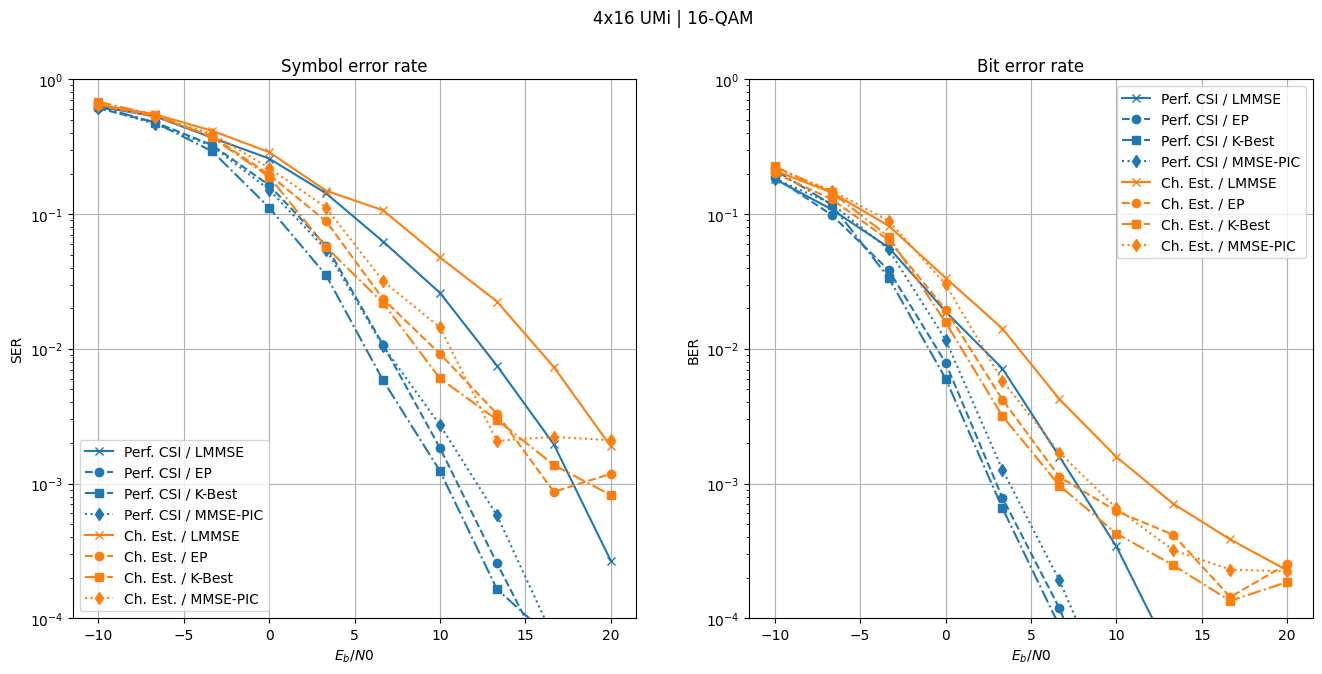

In [21]:
fig, ax = plt.subplots(1,2, figsize=(16,7))
fig.suptitle(f"{NUM_TX}x{NUM_RX_ANT} UMi | {2**NUM_BITS_PER_SYMBOL}-QAM")

## SER

ax[0].set_title("Symbol error rate")
# Perfect CSI
ax[0].semilogy(EBN0_DBs, SER['Perf. CSI / LMMSE'], 'x-', label='Perf. CSI / LMMSE', c='C0')
ax[0].semilogy(EBN0_DBs, SER['Perf. CSI / EP'], 'o--', label='Perf. CSI / EP', c='C0')
ax[0].semilogy(EBN0_DBs, SER['Perf. CSI / K-Best'], 's-.', label='Perf. CSI / K-Best', c='C0')
ax[0].semilogy(EBN0_DBs, SER['Perf. CSI / MMSE-PIC'], 'd:', label='Perf. CSI / MMSE-PIC', c='C0')

# Imperfect CSI
ax[0].semilogy(EBN0_DBs, SER['Ch. Est. / LMMSE'], 'x-', label='Ch. Est. / LMMSE', c='C1')
ax[0].semilogy(EBN0_DBs, SER['Ch. Est. / EP'], 'o--', label='Ch. Est. / EP', c='C1')
ax[0].semilogy(EBN0_DBs, SER['Ch. Est. / K-Best'], 's-.', label='Ch. Est. / K-Best', c='C1')
ax[0].semilogy(EBN0_DBs, SER['Ch. Est. / MMSE-PIC'], 'd:', label='Ch. Est. / MMSE-PIC', c='C1')

ax[0].set_xlabel(r"$E_b/N0$")
ax[0].set_ylabel("SER")
ax[0].set_ylim((1e-4, 1.0))
ax[0].legend()
ax[0].grid(True)

## SER

ax[1].set_title("Bit error rate")
# Perfect CSI
ax[1].semilogy(EBN0_DBs, BER['Perf. CSI / LMMSE'], 'x-', label='Perf. CSI / LMMSE', c='C0')
ax[1].semilogy(EBN0_DBs, BER['Perf. CSI / EP'], 'o--', label='Perf. CSI / EP', c='C0')
ax[1].semilogy(EBN0_DBs, BER['Perf. CSI / K-Best'], 's-.', label='Perf. CSI / K-Best', c='C0')
ax[1].semilogy(EBN0_DBs, BER['Perf. CSI / MMSE-PIC'], 'd:', label='Perf. CSI / MMSE-PIC', c='C0')

# Imperfect CSI
ax[1].semilogy(EBN0_DBs, BER['Ch. Est. / LMMSE'], 'x-', label='Ch. Est. / LMMSE', c='C1')
ax[1].semilogy(EBN0_DBs, BER['Ch. Est. / EP'], 'o--', label='Ch. Est. / EP', c='C1')
ax[1].semilogy(EBN0_DBs, BER['Ch. Est. / K-Best'], 's-.', label='Ch. Est. / K-Best', c='C1')
ax[1].semilogy(EBN0_DBs, BER['Ch. Est. / MMSE-PIC'], 'd:', label='Ch. Est. / MMSE-PIC', c='C1')

ax[1].set_xlabel(r"$E_b/N0$")
ax[1].set_ylabel("BER")
ax[1].set_ylim((1e-4, 1.0))
ax[1].legend()
ax[1].grid(True)

For this setup, the non-linear detection algorithms K-Best, EP, and MMSE-PIC, outperform the linear MMSE detection method.
It is remarkable that K-Best and EP with imperfect CSI achieve lower BER than LMMSE detection with perfect CSI.

However, one should keep in mind that:

- EP is prone to numerical imprecision and could therefore achieve better BER/SER with double precision (`dtype=tf.complex128`). The number of iterations `l` as well as the update smoothing parameter `beta` impact performance.

- For K-Best, there is not a unique way to compute soft information and better performance could be achieved with improved methods for computing soft information from a list of candidates (see [list2llr](https://nvlabs.github.io/sionna/phy/api/mimo.html#sionna.phy.mimo.List2LLR)). Increasing the list size `k` results in improved accuracy at the cost of higher complexity.

- MMSE-PIC can be easily combined with a decoder to implement iterative detection and decoding, as it takes as input soft prior information on the bits/symbols.